# Lateness

- berücksichtigt auch eine negative Abweichung, also wenn ein Job früher fertiggestellt wurde als geplant.

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**  
- $L_j = 0$: Job ist **pünktlich**  
- $L_j < 0$: Job ist **zu früh** fertig

In [4]:
max_time = 60 * 60 * 5 # 5 h

In [5]:
import time

In [6]:
import math
import pulp
import pandas as pd

pd.set_option('display.max_rows', 11)

In [7]:
import utils.presenter as show
import utils.checker as check

import utils.rolling_planning.init_jobs_times as rp_init
import utils.schedule_deadline as deadline_gen

In [8]:
import utils.scheduling_solver as ssv

In [9]:
df_instance= pd.read_csv("data/00_instance.csv")

df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 1, u_b_mmax= 0.9)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
185,Job_018,5,M9,76
186,Job_018,6,M5,47
187,Job_018,7,M3,52
188,Job_018,8,M4,90


In [10]:
df_arrivals

,Job,Arrival
0,Job_000,0.00
1,Job_001,88.05
2,Job_002,152.78
3,Job_003,207.97
4,Job_004,246.61
...,...,...
14,Job_014,1190.89
15,Job_015,1197.28
16,Job_016,1198.72
17,Job_017,1324.04


In [11]:
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1, buffer_factor=1.2)
df_times

,Job,Arrival,Deadline
0,Job_000,0.00,1069.346415
1,Job_001,88.05,1468.725117
2,Job_002,152.78,1690.473072
3,Job_003,207.97,1981.190004
4,Job_004,246.61,1310.542002
...,...,...,...
14,Job_014,1190.89,2964.110004
15,Job_015,1197.28,2261.212002
16,Job_016,1198.72,2736.413072
17,Job_017,1324.04,2393.386415


## a) Absolute Lateness Summe

$$
\min \sum_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **Summe aller Abweichungen zur Deadline**, unabhängig davon, ob ein Job zu früh oder zu spät fertig wird.  
Sie fördert eine **gleichmäßige, zentrierte Fertigstellung** aller Jobs um ihre Soll-Zeitpunkte (Deadlines).



In [14]:
import pandas as pd
import pulp
import math

def solve_jssp_sum_absolute_lateness( df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame, solver: str = 'HiGHS', 
                                     epsilon: float = 0.0, sort_ascending: bool = False,  **solver_args) -> pd.DataFrame:
    """
    Minimiert die Summe der absoluten Lateness (Früh- oder Spätfertigung) aller Jobs.
    Zielfunktion: sum_j [ |C_j - d_j| ]

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - df_arrivals_deadlines: DataFrame mit ['Job','Arrival','Deadline'].
    - solver: 'CBC' oder 'HiGHS' (case-insensitive).
    - epsilon: Pufferzeit zwischen Operationen auf derselben Maschine.
    - sort_ascending: Sortiert die Jobs nach Deadline.
    - **solver_args: Weitere Solver-Parameter wie msg=True, timeLimit=1200 etc.

    Rückgabe:
    - DataFrame mit ['Job','Operation','Arrival','Deadline','Machine',
      'Start','Processing Time','End','Lateness','Absolute Lateness'].
    """

    # 1. Vorverarbeitung
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # BigM berechnen
    sum_proc_time = df_jssp["Processing Time"].sum()
    min_arrival = min(arrival.values())
    max_deadline = max(deadline.values())
    num_machines = df_jssp["Machine"].nunique()
    
    bigM_raw = max_deadline - min_arrival + sum_proc_time / math.sqrt(num_machines)
    bigM = math.ceil(bigM_raw / 1000) * 1000
    print(f"BigM: {bigM}")

    # 2. Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = row["Operation"]
            m = str(row["Machine"])
            d = float(row["Processing Time"])
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    n = len(jobs)

    # 3. Modell
    prob = pulp.LpProblem("JSSP_SumAbsoluteLateness", pulp.LpMinimize)

    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=arrival[jobs[j]])
        for j in range(n)
        for o in range(len(all_ops[j]))
    }

    ends = {
        j: pulp.LpVariable(f"end_{j}", lowBound=arrival[jobs[j]])
        for j in range(n)
    }

    abs_lateness = {
        j: pulp.LpVariable(f"abs_lateness_{j}", lowBound=0)
        for j in range(n)
    }

    # Zielfunktion
    prob += pulp.lpSum(abs_lateness[j] for j in range(n))

    # 4. Technologische Reihenfolge & Lateness
    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o in range(1, len(seq)):
            d_prev = seq[o - 1][2]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

        d_last = seq[-1][2]
        prob += ends[j] == starts[(j, len(seq) - 1)] + d_last

        # Absolute Lateness: max(±(End - Deadline))
        lateness = ends[j] - deadline[job]
        prob += abs_lateness[j] >= lateness
        prob += abs_lateness[j] >= -lateness

    # 5. Maschinenkonflikte
    for m in machines:
        ops_on_m = [
            (j, o, seq[o][2])
            for j, seq in enumerate(all_ops)
            for o in range(len(seq))
            if seq[o][1] == m
        ]
        for i in range(len(ops_on_m)):
            j1, o1, d1 = ops_on_m[i]
            for j2, o2, d2 in ops_on_m[i + 1:]:
                if j1 == j2:
                    continue
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # 6. Solverwahl
    solver_args.setdefault("msg", True)
    solver = solver.upper()
    if solver == "HIGHS":
        cmd = pulp.HiGHS_CMD(**solver_args)
    elif solver == "CBC":
        cmd = pulp.PULP_CBC_CMD(**solver_args)
    else:
        raise ValueError("Solver must be 'CBC' or 'HiGHS'")

    prob.solve(cmd)
    objective_value = pulp.value(prob.objective)

    # 7. Ergebnis extrahieren
    records = []
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            st = starts[(j, o)].varValue
            ed = st + d
            lateness = round(ed - deadline[job], 2)
            records.append({
                "Job": job,
                "Operation": op_id,
                "Arrival": arrival[job],
                "Deadline": deadline[job],
                "Machine": m,
                "Start": round(st, 2),
                "Processing Time": d,
                "End": round(ed, 2),
                "Lateness": lateness,
                "Absolute Lateness": abs(lateness)
            })

    df_schedule = (
        pd.DataFrame.from_records(records)
        .sort_values(["Start", "Job", "Operation"])
        .reset_index(drop=True)
    )

    # 8. Logging
    print("\nSolver-Informationen:")
    print(f"  Summe Absolute Lateness : {round(objective_value, 4)}")
    print(f"  Solver-Status           : {pulp.LpStatus[prob.status]}")
    print(f"  Anzahl Variablen        : {len(prob.variables())}")
    print(f"  Anzahl Constraints      : {len(prob.constraints)}")

    return df_schedule


In [15]:
starting_time = time.time()

# Scheduling
df_plan_sum_l = solve_jssp_sum_absolute_lateness(df_jssp, df_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_sum_l

BigM: 7000

Solver-Informationen:
  Summe Absolute Lateness : 112.9457
  Solver-Status           : Optimal
  Anzahl Variablen        : 1938
  Anzahl Constraints      : 3648

Scheduling-Dauer: 3 Minuten und 0.38 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,Job_000,0,0.00,1069.346415,M0,0.00,29.0,29.00,-1040.35,1040.35
1,Job_000,1,0.00,1069.346415,M1,29.00,78.0,107.00,-962.35,962.35
2,Job_001,0,88.05,1468.725117,M0,88.05,43.0,131.05,-1337.68,1337.68
3,Job_000,2,0.00,1069.346415,M2,107.00,9.0,116.00,-953.35,953.35
4,Job_000,3,0.00,1069.346415,M3,116.00,36.0,152.00,-917.35,917.35
...,...,...,...,...,...,...,...,...,...,...
185,Job_018,8,1429.61,2891.501301,M4,2756.50,90.0,2846.50,-45.00,45.00
186,Job_014,7,1190.89,2964.110004,M3,2772.19,98.0,2870.19,-93.92,93.92
187,Job_018,9,1429.61,2891.501301,M7,2846.50,45.0,2891.50,0.00,0.00
188,Job_014,8,1190.89,2964.110004,M9,2870.19,22.0,2892.19,-71.92,71.92


In [16]:
show.count_column_grouped(df_plan_sum_l, 'Absolute Lateness')

<0            0
0            14
0-30          3
30-60         3
60-120        6
120-240      11
240-480      40
480-720      30
720-1440     83
1440-2880     0
>2880         0
dtype: int32

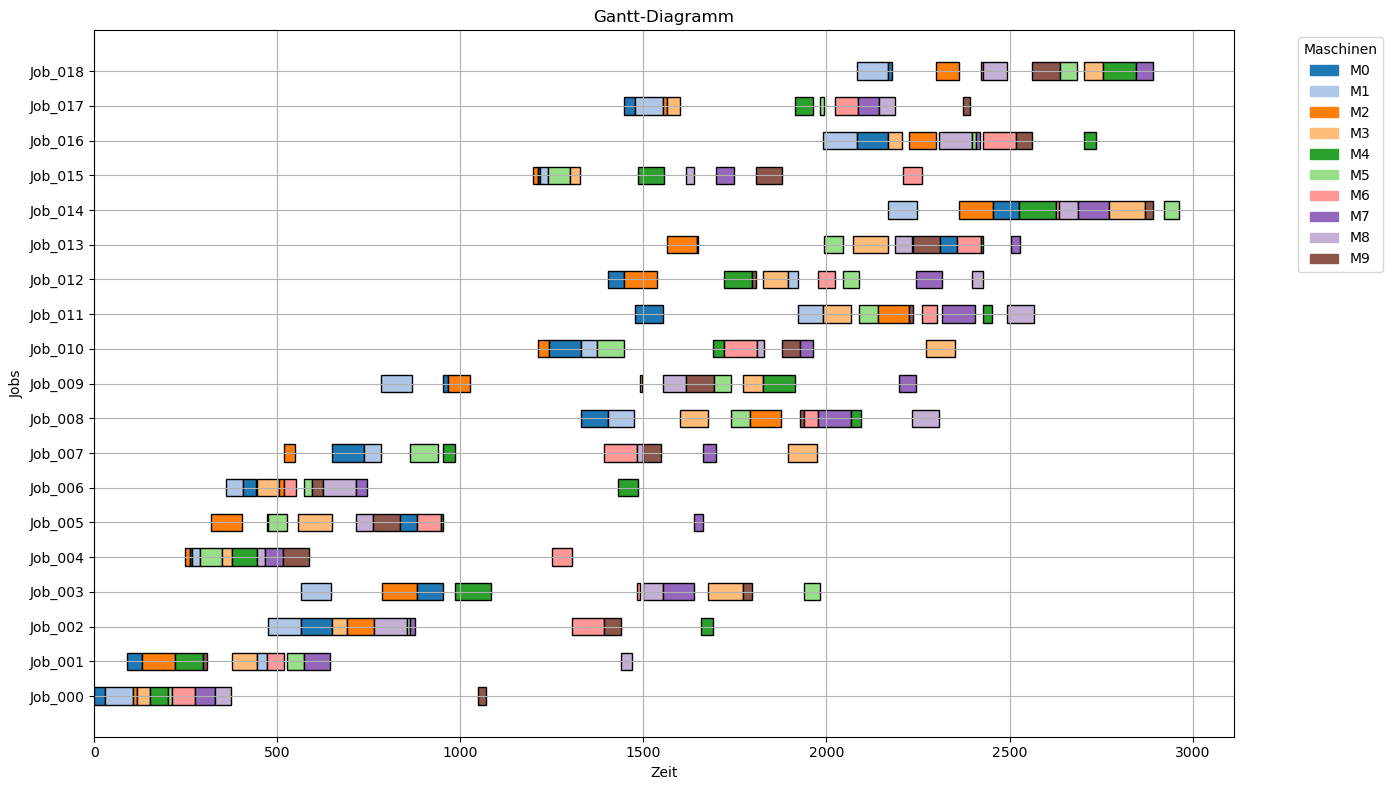

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [17]:
df_plan = df_plan_sum_l

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## b) größte absolute Lateness minimieren

$$
\min \; \max_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **größte Abweichung** eines Jobs zur Deadline – unabhängig davon, ob der Job **zu früh oder zu spät** fertiggestellt wurde.  
Sie sorgt dafür, dass **kein Job extrem abweicht**, und behandelt **Früh- und Spätfertigstellungen gleichwertig**.


In [20]:
import pandas as pd
import pulp
import math

def solve_jssp_max_absolute_lateness(df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame, solver: str = 'HiGHS',
                                     epsilon: float = 0.0, sort_ascending: bool = False, **solver_args) -> pd.DataFrame:
    """
    Minimiert die maximale absolute Lateness (Früh- oder Spätfertigung) über alle Jobs.
    Zielfunktion: min max_j [ |C_j - d_j| ]

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - df_arrivals_deadlines: DataFrame mit ['Job','Arrival','Deadline'].
    - solver: 'CBC' oder 'HiGHS' (case-insensitive).
    - epsilon: Pufferzeit zwischen Jobs auf derselben Maschine.
    - sort_ascending: Sortiert nach Deadline.
    - **solver_args: Weitere Solver-Parameter (msg=True, timeLimit=1200 etc.)

    Rückgabe:
    - df_schedule: DataFrame mit ['Job','Operation','Arrival','Deadline',
      'Machine','Start','Processing Time','End','Lateness','Absolute Lateness'].
    """

    # 1. Vorverarbeitung
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # BigM berechnen
    sum_proc_time = df_jssp["Processing Time"].sum()
    min_arrival = min(arrival.values())
    max_deadline = max(deadline.values())
    num_machines = df_jssp["Machine"].nunique()
    
    bigM_raw = max_deadline - min_arrival + sum_proc_time / math.sqrt(num_machines)
    bigM = math.ceil(bigM_raw / 1000) * 1000
    print(f"BigM: {bigM}")

    # 2. Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = row["Operation"]
            m = str(row["Machine"])
            d = float(row["Processing Time"])
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    n = len(jobs)

    # 3. LP-Modell
    prob = pulp.LpProblem("JSSP_MaxAbsLateness", pulp.LpMinimize)

    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=arrival[jobs[j]])
        for j in range(n)
        for o in range(len(all_ops[j]))
    }

    ends = {
        j: pulp.LpVariable(f"end_{j}", lowBound=arrival[jobs[j]])
        for j in range(n)
    }

    abs_lateness = {
        j: pulp.LpVariable(f"abs_lateness_{j}", lowBound=0)
        for j in range(n)
    }

    max_abs_lateness = pulp.LpVariable("max_abs_lateness", lowBound=0)

    # Zielfunktion: minimiert die maximale absolute Lateness
    prob += max_abs_lateness

    # 4. Technologische Reihenfolge und Abweichungen
    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o in range(1, len(seq)):
            d_prev = seq[o - 1][2]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

        d_last = seq[-1][2]
        prob += ends[j] == starts[(j, len(seq) - 1)] + d_last

        lateness = ends[j] - deadline[job]
        prob += abs_lateness[j] >= lateness
        prob += abs_lateness[j] >= -lateness
        prob += max_abs_lateness >= abs_lateness[j]

    # 5. Maschinenkonflikte
    for m in machines:
        ops_on_m = [
            (j, o, seq[o][2])
            for j, seq in enumerate(all_ops)
            for o in range(len(seq))
            if seq[o][1] == m
        ]
        for i in range(len(ops_on_m)):
            j1, o1, d1 = ops_on_m[i]
            for j2, o2, d2 in ops_on_m[i + 1:]:
                if j1 == j2:
                    continue
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # 6. Solverwahl
    solver_args.setdefault("msg", True)
    solver = solver.upper()
    if solver == "HIGHS":
        cmd = pulp.HiGHS_CMD(**solver_args)
    elif solver == "CBC":
        cmd = pulp.PULP_CBC_CMD(**solver_args)
    else:
        raise ValueError("Solver must be 'CBC' or 'HiGHS'")

    prob.solve(cmd)
    objective_value = pulp.value(prob.objective)

    # 7. Ergebnis extrahieren
    records = []
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            st = starts[(j, o)].varValue
            ed = st + d
            lateness = round(ed - deadline[job], 2)
            records.append({
                "Job": job,
                "Operation": op_id,
                "Arrival": arrival[job],
                "Deadline": deadline[job],
                "Machine": m,
                "Start": round(st, 2),
                "Processing Time": d,
                "End": round(ed, 2),
                "Lateness": lateness,
                "Absolute Lateness": abs(lateness)
            })

    df_schedule = (
        pd.DataFrame.from_records(records)
        .sort_values(["Start", "Job", "Operation"])
        .reset_index(drop=True)
    )

    # 8. Logging
    print("\nSolver-Informationen:")
    print(f"  Maximale absolute Lateness: {round(objective_value, 4)}")
    print(f"  Solver-Status             : {pulp.LpStatus[prob.status]}")
    print(f"  Anzahl Variablen          : {len(prob.variables())}")
    print(f"  Anzahl Constraints        : {len(prob.constraints)}")

    return df_schedule


In [21]:
starting_time = time.time()

# Scheduling
df_plan_max_l = solve_jssp_max_absolute_lateness(df_jssp, df_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_max_l

BigM: 7000

Solver-Informationen:
  Maximale absolute Lateness: 5.0035
  Solver-Status             : Optimal
  Anzahl Variablen          : 1939
  Anzahl Constraints        : 3667

Scheduling-Dauer: 0 Minuten und 18.90 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,Job_000,0,0.00,1069.346415,M0,0.00,29.0,29.00,-1040.35,1040.35
1,Job_000,1,0.00,1069.346415,M1,29.00,78.0,107.00,-962.35,962.35
2,Job_000,2,0.00,1069.346415,M2,107.00,9.0,116.00,-953.35,953.35
3,Job_000,3,0.00,1069.346415,M3,116.00,36.0,152.00,-917.35,917.35
4,Job_000,4,0.00,1069.346415,M4,152.00,49.0,201.00,-868.35,868.35
...,...,...,...,...,...,...,...,...,...,...
185,Job_014,7,1190.89,2964.110004,M3,2753.61,98.0,2851.61,-112.50,112.50
186,Job_018,8,1429.61,2891.501301,M4,2753.61,90.0,2843.61,-47.89,47.89
187,Job_018,9,1429.61,2891.501301,M7,2851.50,45.0,2896.50,5.00,5.00
188,Job_014,8,1190.89,2964.110004,M9,2851.61,22.0,2873.61,-90.50,90.50


In [22]:
show.count_column_grouped(df_plan_max_l, 'Absolute Lateness')

<0            0
0             0
0-30         19
30-60         1
60-120        8
120-240      20
240-480      42
480-720      23
720-1440     77
1440-2880     0
>2880         0
dtype: int32

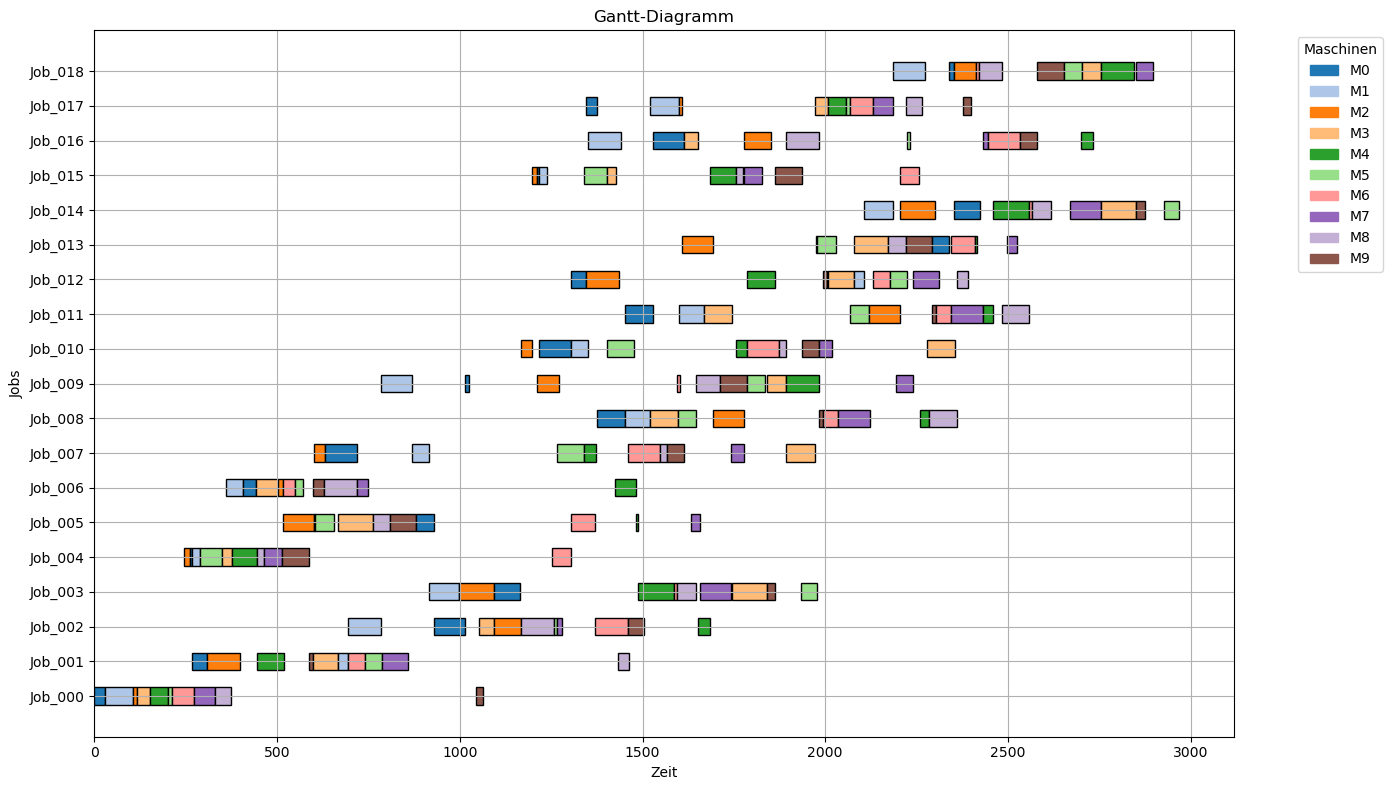

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [23]:
df_plan = df_plan_max_l

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)